In [737]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


%matplotlib inline
pd.set_option("display.max_rows", None, "display.max_columns", None)
warnings.simplefilter(action='ignore')
plt.style.use('seaborn')


In [738]:
df_main = pd.read_csv('Crawl/Data/Perfume_Data.csv')
df_main.head()

,Unnamed: 0.1,Unnamed: 0,name,brand,pricenew,sale,priceold
0,0,0,Nước Hoa Nữ Diamond Femme 45ml (Trắng),Eau De Parfum,301.000 ₫,45%,549.000 ₫
1,1,1,Nước Hoa Vùng Kín Foellie Hương Hoa Hồng Mạnh ...,Inner Perfume #Eau De Bijou,144.000 ₫,59%,350.000 ₫
2,2,2,Nước Hoa Nữ Diamond Femme Pink 45ml (Hồng),Eau De Parfum,275.000 ₫,50%,549.000 ₫
3,3,3,Nước Hoa Nam Diamond Homme 45ml (Đen),Eau De Parfum,275.000 ₫,50%,549.000 ₫
4,4,4,Nước Hoa Nữ Diamond Femme Ruby Red 45ml (Đỏ),Eau De Parfum,301.000 ₫,45%,549.000 ₫


In [739]:
print(df_main.shape)

(263, 7)


In [740]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0.1  263 non-null    int64 
 1   Unnamed: 0    263 non-null    int64 
 2   name          263 non-null    object
 3   brand         230 non-null    object
 4   pricenew      263 non-null    object
 5   sale          252 non-null    object
 6   priceold      252 non-null    object
dtypes: int64(2), object(5)
memory usage: 14.5+ KB


In [741]:
df_main.describe()

,Unnamed: 0.1,Unnamed: 0
count,263.000000,263.000000
mean,131.000000,78.711027
std,76.065761,55.149140
min,0.000000,0.000000
25%,65.500000,32.500000
50%,131.000000,65.000000
75%,196.500000,124.500000
max,262.000000,190.000000


In [742]:
print(df_main.isna().sum())

Unnamed: 0.1     0
Unnamed: 0       0
name             0
brand           33
pricenew         0
sale            11
priceold        11
dtype: int64


In [743]:
# Tiền xử lý dữ liệu
# Loại bỏ ký hiệu tiền tệ, dấu phân cách và khoảng trắng, sau đó chuyển đổi giá trị thành số thực
df_main['pricenew'] = df_main['pricenew'].str.replace('₫', '').str.replace('.', '').str.replace(' ', '').astype(float)
df_main['priceold'] = df_main['priceold'].str.replace('₫', '').str.replace('.', '').str.replace(' ', '').astype(float)


In [744]:
# Xử lý cột 'sale' để chuyển đổi thành phần trăm giảm giá
# Loại bỏ ký hiệu phần trăm và các ký tự không mong muốn
df_main['sale'] = df_main['sale'].str.replace('%', '').str.replace('(', '').str.replace(')', '').str.replace('-', '')


In [745]:
# Chuyển đổi giá trị thành số thực
df_main['discount_percent'] = pd.to_numeric(df_main['sale'], errors='coerce')


In [746]:
# Đổi tên cột cho phù hợp với ngữ cảnh
df_main.rename(columns={'name': 'Tên_Sản_Phẩm', 'brand': 'Thương_Hiệu', 'pricenew': 'Giá_Bán', 'priceold': 'Giá_Gốc', 'discount_percent': 'Phần_Trăm_Giảm'}, inplace=True)


In [747]:
# Loại bỏ các cột không cần thiết
df_main.drop(columns=['Unnamed: 0', 'sale'], inplace=True)


In [748]:
# Hiển thị dataframe đã được chỉnh sửa
df_main.head()

,Unnamed: 0.1,Tên_Sản_Phẩm,Thương_Hiệu,Giá_Bán,Giá_Gốc,Phần_Trăm_Giảm
0,0,Nước Hoa Nữ Diamond Femme 45ml (Trắng),Eau De Parfum,301000.0,549000.0,45.0
1,1,Nước Hoa Vùng Kín Foellie Hương Hoa Hồng Mạnh ...,Inner Perfume #Eau De Bijou,144000.0,350000.0,59.0
2,2,Nước Hoa Nữ Diamond Femme Pink 45ml (Hồng),Eau De Parfum,275000.0,549000.0,50.0
3,3,Nước Hoa Nam Diamond Homme 45ml (Đen),Eau De Parfum,275000.0,549000.0,50.0
4,4,Nước Hoa Nữ Diamond Femme Ruby Red 45ml (Đỏ),Eau De Parfum,301000.0,549000.0,45.0


In [749]:
# Phân tích dữ liệu thăm dò (EDA)
# Định nghĩa các cột phân loại để trực quan hóa
cat_cols = ['Thương_Hiệu']

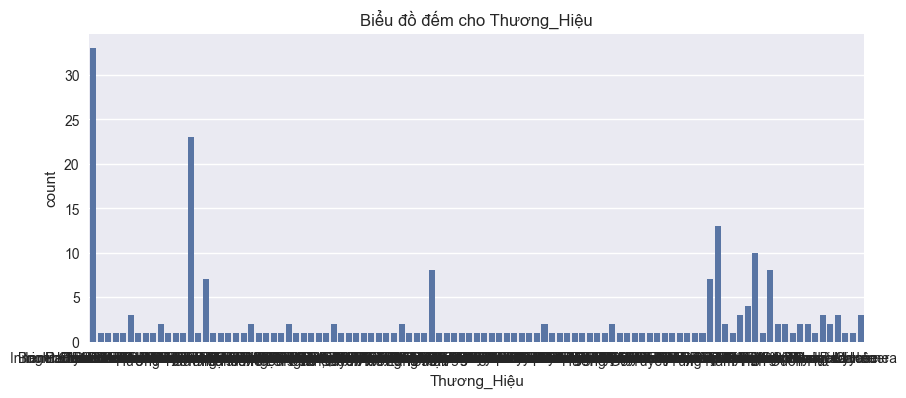

In [750]:
# Vẽ biểu đồ đếm cho các cột phân loại
for col in cat_cols:
    plt.figure(figsize=[10, 4])
    sns.countplot(x=col, data=df_main)
    plt.title(f'Biểu đồ đếm cho {col}')
    plt.show()

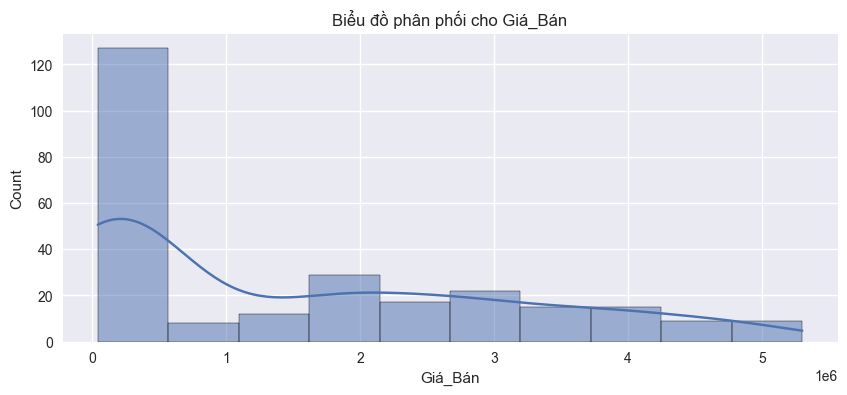

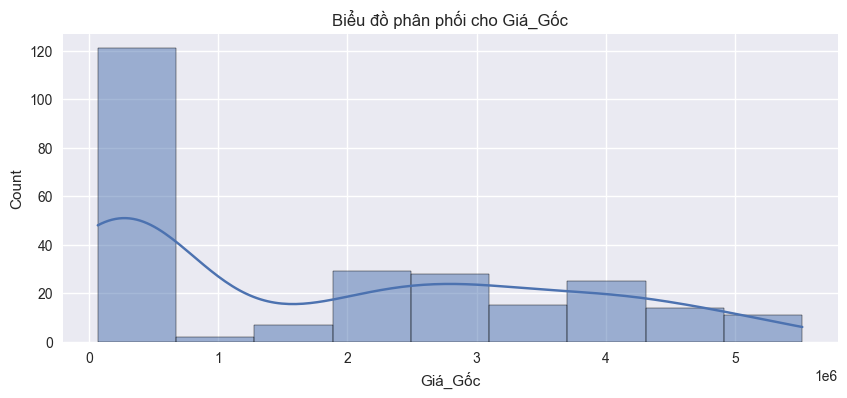

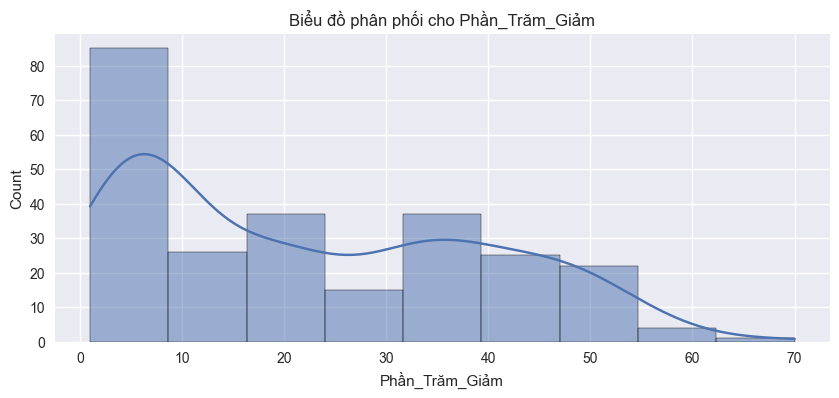

In [751]:
# Nếu bạn có các cột số liệu muốn phân tích, bạn có thể vẽ biểu đồ phân phối
num_cols = ['Giá_Bán', 'Giá_Gốc', 'Phần_Trăm_Giảm']
for col in num_cols:
    plt.figure(figsize=[10, 4])
    sns.histplot(df_main[col], kde=True)
    plt.title(f'Biểu đồ phân phối cho {col}')
    plt.show()

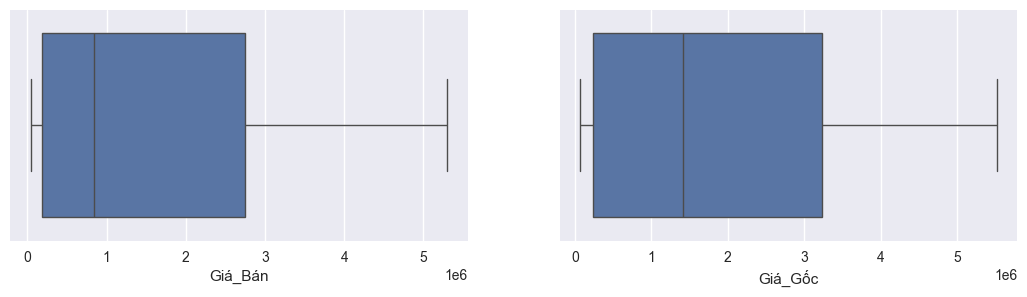

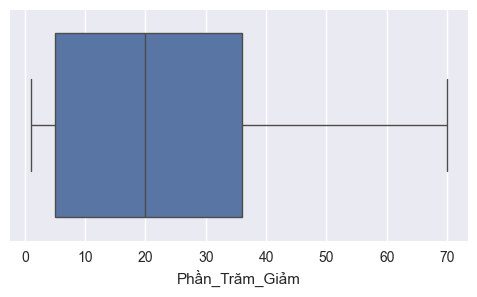

In [752]:
# Định nghĩa các cột số liệu để phân tích
num_cols = ['Giá_Bán', 'Giá_Gốc', 'Phần_Trăm_Giảm']
i = 0
while i < len(num_cols):
    fig = plt.figure(figsize=[13, 3])
    
    # Vẽ biểu đồ boxplot cho từng cột
    plt.subplot(1, 2, 1)
    sns.boxplot(x=num_cols[i], data=df_main)
    i += 1
    
    if i < len(num_cols):  # Kiểm tra để tránh vượt quá danh sách các cột
        plt.subplot(1, 2, 2)
        sns.boxplot(x=num_cols[i], data=df_main)
        i += 1
    
    plt.show()

In [753]:
# Hiển thị các hàng có giá bán cao hơn ngưỡng 99%
print(df_main[df_main['Giá_Bán'] > df_main['Giá_Bán'].quantile(0.99)])


     Unnamed: 0.1                                       Tên_Sản_Phẩm  \
196           196                       Nước hoa YSL Y Le Parfum EDP   
227           227  Nước hoa Yves Saint Laurent Libre L'Absolu Pla...   
230           230  Nước hoa Dolce & Gabbana The Only One EDP Intense   

            Thương_Hiệu    Giá_Bán    Giá_Gốc  Phần_Trăm_Giảm  
196  Yves Saint Laurent  5241000.0  5460000.0             4.0  
227  Yves Saint Laurent  5299000.0  5520000.0             4.0  
230     Dolce & Gabbana  5040000.0  5250000.0             4.0  


In [754]:

# Hiển thị các hàng có giá gốc cao hơn ngưỡng 99%
print(df_main[df_main['Giá_Gốc'] > df_main['Giá_Gốc'].quantile(0.99)])


     Unnamed: 0.1                                       Tên_Sản_Phẩm  \
196           196                       Nước hoa YSL Y Le Parfum EDP   
227           227  Nước hoa Yves Saint Laurent Libre L'Absolu Pla...   
242           242       Nước hoa Chloé Signature Lumineuse Roses EDP   

            Thương_Hiệu    Giá_Bán    Giá_Gốc  Phần_Trăm_Giảm  
196  Yves Saint Laurent  5241000.0  5460000.0             4.0  
227  Yves Saint Laurent  5299000.0  5520000.0             4.0  
242               Chloe  4949000.0  5380000.0             8.0  


In [755]:
# Hiển thị các hàng có phần trăm giảm giá cao hơn ngưỡng 99%
print(df_main[df_main['Phần_Trăm_Giảm'] > df_main['Phần_Trăm_Giảm'].quantile(0.99)])


     Unnamed: 0.1                                       Tên_Sản_Phẩm  \
1               1  Nước Hoa Vùng Kín Foellie Hương Hoa Hồng Mạnh ...   
31             31        Nước Hoa Nữ Versace Bright Crystal EDT 50ml   
181           181  [HSD 07/2024] Nước Hoa Nữ Trussardi Sound Of D...   

                              Thương_Hiệu    Giá_Bán    Giá_Gốc  \
1             Inner Perfume #Eau De Bijou   144000.0   350000.0   
31   Bright Crystal Eau de Toilette Spray  1190000.0  2905000.0   
181    Sound Of Donna Eau De Parfum Spray   726000.0  2420000.0   

     Phần_Trăm_Giảm  
1              59.0  
31             59.0  
181            70.0  


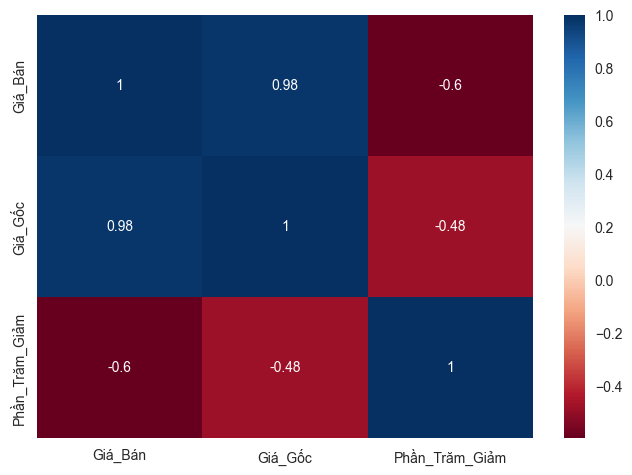

Giá_Bán           1.000000
Giá_Gốc           0.978363
Phần_Trăm_Giảm   -0.597171
Name: Giá_Bán, dtype: float64


In [756]:
# Lọc các cột số liệu
numeric_df = df_main[['Giá_Bán', 'Giá_Gốc', 'Phần_Trăm_Giảm']]

# Vẽ biểu đồ heatmap để hiển thị tương quan giữa các biến
sns.heatmap(numeric_df.corr(), annot=True, cmap="RdBu")
plt.show()

# Hiển thị tương quan của cột 'Giá_Bán' với các cột khác
print(numeric_df.corr()['Giá_Bán'])


In [757]:
# Thay thế NaN trong cột 'Thương_Hiệu' bằng 'Elite Perfume'
df_main['Thương_Hiệu'].fillna('Elite Perfume', inplace=True)
df_main['Phần_Trăm_Giảm'] = df_main['Phần_Trăm_Giảm'].fillna(0.0)
df_main.loc[df_main['Phần_Trăm_Giảm'] == 0.0, 'Giá_Gốc'] = df_main['Giá_Bán']

df_main = df_main.drop(columns=['Unnamed: 0.1', 'Tên_Sản_Phẩm'])  # Loại bỏ các cột không cần thiết
X = df_main.drop(columns=['Giá_Bán'])  # Biến đầu vào
y = df_main['Giá_Bán']  # Biến mục tiêu




In [758]:
df_main.head()


,Thương_Hiệu,Giá_Bán,Giá_Gốc,Phần_Trăm_Giảm
0,Eau De Parfum,301000.0,549000.0,45.0
1,Inner Perfume #Eau De Bijou,144000.0,350000.0,59.0
2,Eau De Parfum,275000.0,549000.0,50.0
3,Eau De Parfum,275000.0,549000.0,50.0
4,Eau De Parfum,301000.0,549000.0,45.0


In [759]:
# Chuyển đổi các biến phân loại thành biến số (One-Hot Encoding)
X = pd.get_dummies(X, drop_first=True)

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

CV = []
R2_train = []
R2_test = []

In [760]:
# Phân chia dữ liệu thành tập huấn luyện và tập kiểm tra

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (210, 105)
X_test shape: (53, 105)
y_train shape: (210,)
y_test shape: (53,)


In [761]:
def perfume_pred_model(model, model_name):
    # Huấn luyện mô hình
    model.fit(X_train, y_train)
            
    # R2 score của tập huấn luyện
    y_pred_train = model.predict(X_train)
    R2_train_model = r2_score(y_train, y_pred_train)
    R2_train.append(round(R2_train_model, 2))
    
    # R2 score của tập kiểm tra
    y_pred_test = model.predict(X_test)
    R2_test_model = r2_score(y_test, y_pred_test)
    R2_test.append(round(R2_test_model, 2))
    
    # R2 mean của tập huấn luyện sử dụng Cross validation
    cross_val = cross_val_score(model, X_train, y_train, cv=5)
    cv_mean = cross_val.mean()
    CV.append(round(cv_mean, 2))
    
    # In kết quả
    print("Train R2-score:", round(R2_train_model, 2))
    print("Test R2-score:", round(R2_test_model, 2))
    print("Train CV scores:", cross_val)
    print("Train CV mean:", round(cv_mean, 2))
    
    # Vẽ đồ thị
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    
    # Residual Plot của dữ liệu huấn luyện
    ax[0].set_title('Residual Plot of Train samples')
    sns.distplot((y_train - y_pred_train), hist=False, ax=ax[0])
    ax[0].set_xlabel('y_train - y_pred_train')
    
    # Đồ thị scatter giữa y_test và y_pred_test
    ax[1].set_title('y_test vs y_pred_test')
    ax[1].scatter(x=y_test, y=y_pred_test)
    ax[1].set_xlabel('y_test')
    ax[1].set_ylabel('y_pred_test')
    
    plt.show()



Train R2-score: 0.99
Test R2-score: 0.97
Train CV scores: [0.96861561 0.95966216 0.96161752 0.98346646 0.97463687]
Train CV mean: 0.97


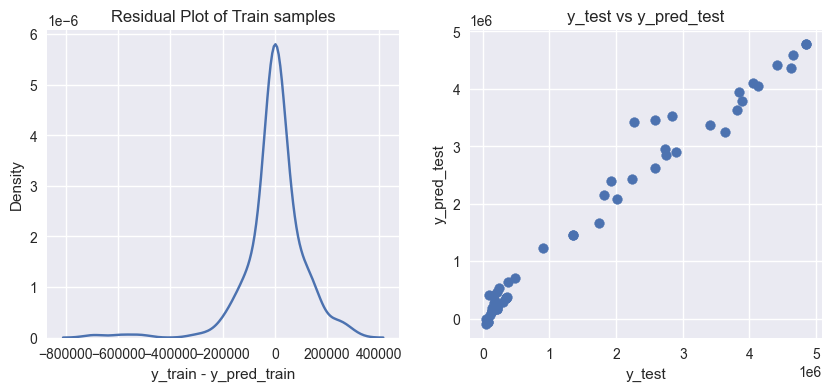

Linear Regression - Mean Absolute Error: 1002698.6857621877
Linear Regression - Mean Squared Error: 1327816054420.7004
Linear Regression - Root Mean Squared Error: 1152309.0099537973
Linear Regression - So sánh giá ban đầu với giá mô hình dự đoán
     Giá_Ban_Dau   Gia_Du_Doan
115    1360000.0  1.653956e+06
120    2583000.0  1.650130e+06
259    4131000.0  2.609851e+06
226    3847000.0  6.329300e+06
66       84000.0  9.051140e+05
249    4848000.0  3.309814e+06
176     168000.0  9.238660e+05
216    2894000.0  3.013953e+06
9       219000.0  1.055736e+06
101    1746000.0  1.055530e+06
24      134000.0  9.162121e+05
111     370000.0  1.046727e+06
46      476000.0  1.652042e+06
223    4626000.0  2.239912e+06
193    2736000.0  3.646152e+06
215    4406000.0  3.309814e+06
79      380000.0  1.653955e+06
6       179000.0  1.635203e+06
255    3895000.0  2.367733e+06
67      231000.0  1.064155e+06
141    2589000.0  1.639797e+06
147    2268000.0  1.636736e+06
19      175000.0  7.434256e+05
254    34

In [762]:
# Linear Regression
linear_reg = LinearRegression()
perfume_pred_model(linear_reg, "linear_regressor.pkl")

# Kiểm thử mô hình Linear Regression
y_pred_test_linear = linear_reg.predict(X_test_scaled)
mae_linear = mean_absolute_error(y_test, y_pred_test_linear)
mse_linear = mean_squared_error(y_test, y_pred_test_linear)
rmse_linear = np.sqrt(mse_linear)
print(f"Linear Regression - Mean Absolute Error: {mae_linear}")
print(f"Linear Regression - Mean Squared Error: {mse_linear}")
print(f"Linear Regression - Root Mean Squared Error: {rmse_linear}")

# So sánh giá ban đầu với giá mô hình dự đoán cho Linear Regression
comparison_df_linear = pd.DataFrame({'Giá_Ban_Dau': y_test, 'Gia_Du_Doan': y_pred_test_linear})
print("Linear Regression - So sánh giá ban đầu với giá mô hình dự đoán")
print(comparison_df_linear)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Train R2-score: 0.99
Test R2-score: 0.98
Train CV scores: [0.97266656 0.97488962 0.97308436 0.98815575 0.98398871]
Train CV mean: 0.98


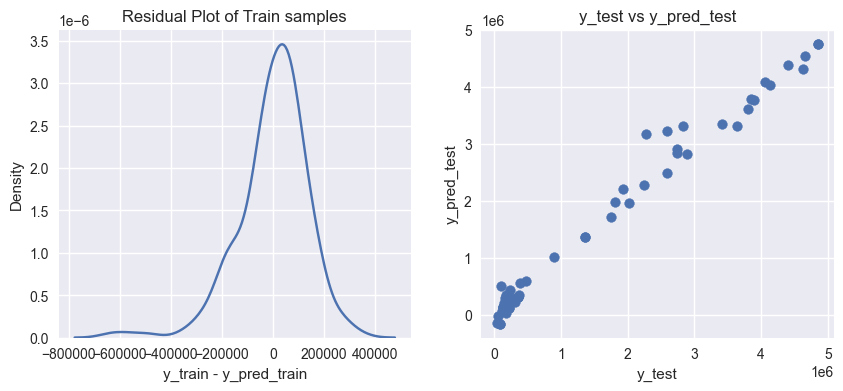

Ridge - Mean Absolute Error: 1180333.3644283381
Ridge - Mean Squared Error: 2619241028657.553
Ridge - Root Mean Squared Error: 1618406.9416118904
Ridge Regression - So sánh giá ban đầu với giá mô hình dự đoán
     Giá_Ban_Dau   Gia_Du_Doan
115    1360000.0  1.019554e+05
120    2583000.0  9.599201e+04
259    4131000.0  1.525243e+06
226    3847000.0  4.055429e+06
66       84000.0 -8.415759e+03
249    4848000.0  2.149692e+06
176     168000.0  2.080862e+04
216    2894000.0  1.956232e+06
9       219000.0  8.135342e+04
101    1746000.0  5.501698e+04
24      134000.0  8.880303e+03
111     370000.0  4.129872e+04
46      476000.0  9.897292e+04
223    4626000.0  1.421124e+06
193    2736000.0  2.508658e+06
215    4406000.0  2.149692e+06
79      380000.0  1.019549e+05
6       179000.0  7.273054e+04
255    3895000.0  1.348835e+06
67      231000.0  9.447453e+04
141    2589000.0  7.988940e+04
147    2268000.0  7.511808e+04
19      175000.0  2.007415e+06
254    3410000.0  1.348834e+06
109    3637000.0

In [763]:
# Ridge Regression
ridge = Ridge()
alpha = np.logspace(-3, 3, 14)
ridge_rs = RandomizedSearchCV(estimator=ridge, param_distributions=dict(alpha=alpha), n_iter=100, cv=5, random_state=1, n_jobs=-1, verbose=2)
perfume_pred_model(ridge_rs, "ridge.pkl")

# Kiểm thử mô hình Ridge Regression
y_pred_test_ridge = ridge_rs.predict(X_test_scaled)
mae_ridge = mean_absolute_error(y_test, y_pred_test_ridge)
mse_ridge = mean_squared_error(y_test, y_pred_test_ridge)
rmse_ridge = np.sqrt(mse_ridge)
print(f"Ridge - Mean Absolute Error: {mae_ridge}")
print(f"Ridge - Mean Squared Error: {mse_ridge}")
print(f"Ridge - Root Mean Squared Error: {rmse_ridge}")

# So sánh giá ban đầu với giá mô hình dự đoán cho Ridge Regression
comparison_df_ridge = pd.DataFrame({'Giá_Ban_Dau': y_test, 'Gia_Du_Doan': y_pred_test_ridge})
print("Ridge Regression - So sánh giá ban đầu với giá mô hình dự đoán")
print(comparison_df_ridge)

In [764]:
# Khởi tạo mô hình Random Forest
rf = RandomForestRegressor(random_state=42)

# Thiết lập các tham số cần tìm kiếm
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid search với cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Huấn luyện mô hình
grid_search.fit(X_train_scaled, y_train)

# In ra các tham số tốt nhất
print(f"Best parameters: {grid_search.best_params_}")

# Sử dụng mô hình tốt nhất để dự đoán
best_rf = grid_search.best_estimator_
perfume_pred_model(best_rf, "RandomForest_regressor.pkl")

# Kiểm thử mô hình
mae = mean_absolute_error(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

# So sánh giá ban đầu với giá mô hình dự đoán
y_pred_test = best_rf.predict(X_test_scaled)
comparison_df = pd.DataFrame({'Giá_Ban_Dau': y_test, 'Gia_Du_Doan': y_pred_test})
print(comparison_df)


Fitting 5 folds for each of 108 candidates, totalling 540 fits


Train R2-score: 1.0
Test R2-score: 1.0
Train CV scores: [0.99768356 0.99012833 0.98339142 0.9993497  0.99539408]
Train CV mean: 0.99


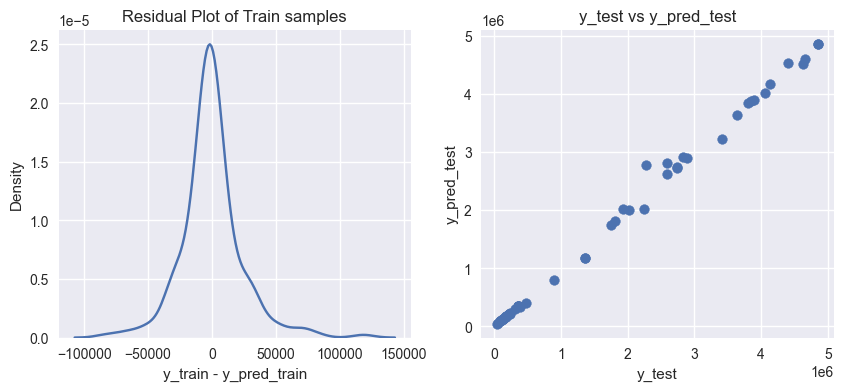

     Giá_Ban_Dau   Gia_Du_Doan
115    1360000.0  1.170938e+06
120    2583000.0  2.623595e+06
259    4131000.0  4.165900e+06
226    3847000.0  3.880874e+06
66       84000.0  8.765276e+04
249    4848000.0  4.868710e+06
176     168000.0  1.662998e+05
216    2894000.0  2.903667e+06
9       219000.0  2.199340e+05
101    1746000.0  1.744862e+06
24      134000.0  1.338530e+05
111     370000.0  3.493616e+05
46      476000.0  4.039920e+05
223    4626000.0  4.522923e+06
193    2736000.0  2.745849e+06
215    4406000.0  4.537153e+06
79      380000.0  3.296644e+05
6       179000.0  1.773304e+05
255    3895000.0  3.896198e+06
67      231000.0  2.188645e+05
141    2589000.0  2.812243e+06
147    2268000.0  2.769774e+06
19      175000.0  1.773304e+05
254    3410000.0  3.224097e+06
109    3637000.0  3.634547e+06
136    1815000.0  1.821602e+06
78      160000.0  1.636927e+05
68       54000.0  6.310615e+04
197    2014000.0  2.007246e+06
15      219000.0  2.199340e+05
30      134000.0  1.338530e+05
172    1

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

# Khởi tạo mô hình Gradient Boosting
gbr = GradientBoostingRegressor(random_state=42)

# Huấn luyện và đánh giá mô hình
perfume_pred_model(gbr, "GradientBoosting_regressor.pkl")

# So sánh giá ban đầu với giá mô hình dự đoán
y_pred_test = gbr.predict(X_test)
comparison_df = pd.DataFrame({'Giá_Ban_Dau': y_test, 'Gia_Du_Doan': y_pred_test})
print(comparison_df)

In [ ]:
# Tổng hợp kết quả
Technique = ["Linear Regression", "Ridge Regression", "Lasso Regression", "Random Forest", "Gradient Boosting"]
results = pd.DataFrame({
    'Model': Technique,
    'R Squared(Train)': R2_train,
    'R Squared(Test)': R2_test,
    'CV score mean(Train)': CV
})
display(results)

,Model,R Squared(Train),R Squared(Test),CV score mean(Train)
0,Linear Regression,0.99,0.97,0.97
1,Ridge Regression,0.99,0.98,0.98
2,Lasso Regression,1.00,0.99,0.99
3,Random Forest,1.00,1.00,0.99
4,Gradient Boosting,1.00,1.00,0.99
